In [1]:
import chess
import cv2 as cv
import matplotlib.pyplot as plt

from detectors.chess_position_detector import ChessPositionDetector

In [2]:
image_path = 'data/chess_pieces/test/images/20240302_125048_jpg.rf.ff88169de27cdca17a43905cbce8049a.jpg'
image_path = 'data/chess_pieces/test/images/20240302_125152_jpg.rf.80fb31461755737012017651243ef606.jpg'
image_path = 'data/chess_pieces/test/images/Screenshot_2567-12-10_at_16.45.27.png'
original_image = cv.imread(image_path, cv.IMREAD_COLOR)

chess_position_detector = ChessPositionDetector()
fen = chess_position_detector.detect(original_image)

print('FEN: {}'.format(fen))

c:\Users\User\anaconda3\envs\digimage\lib\site-packages\torch\cuda\__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


FEN: R1B1Q3/PPK2P1P/5N2/q2P2P1/3pP2n/4p3/1p2bppp/Nnbk3r


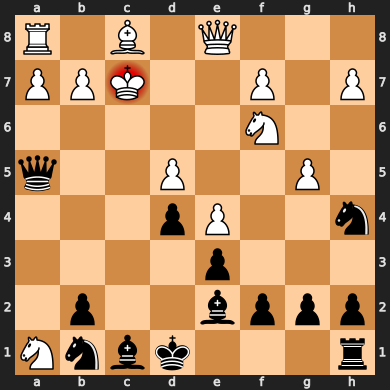

In [3]:
chess.Board(fen)

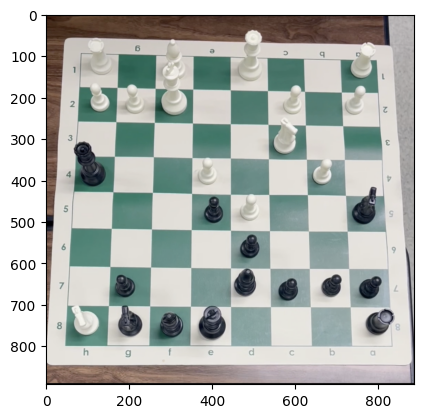

In [4]:
plt.imshow(cv.cvtColor(original_image, cv.COLOR_BGR2RGB))

In [8]:
!pip install scikit-image
!pip install --user mediapipe
!pip install inference
!pip install supervision

  Using cached inference-0.29.2-py3-none-any.whl.metadata (15 kB)
  Using cached aiortc-1.9.0-cp38-abi3-win_amd64.whl.metadata (5.6 kB)
  Using cached APScheduler-3.11.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached asyncua-1.1.5-py3-none-any.whl.metadata (9.5 kB)
  Using cached Cython-3.0.11-cp310-cp310-win_amd64.whl.metadata (3.2 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached fastapi-0.110.3-py3-none-any.whl.metadata (24 kB)
  Using cached pillow-10.4.0-cp310-cp310-win_amd64.whl.metadata (9.3 kB)
  Using cached prometheus_fastapi_instrumentator-6.0.0-py3-none-any.whl.metadata (13 kB)
  Using cached redis-5.0.8-py3-none-any.whl.metadata (9.2 kB)
  Using cached rich-13.0.1-py3-none-any.whl.metadata (18 kB)
  Using cached supervision-0.22.0-py3-none-any.whl.metadata (13 kB)
  Using cached pybase64-1.0.2.tar.gz (105 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements 

  You can safely remove it manually.


In [5]:
import cv2
import numpy as np
import os
from skimage.metrics import structural_similarity as compare_ssim
import torch
import mediapipe as mp
from ultralytics import YOLO
from inference import get_model
import supervision as sv
import cv2
import matplotlib.pyplot as plt

In [6]:
def board_detection(image):
    # Convert to grayscale and binary
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 196, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    largest_contour = max(contours, key=cv2.contourArea)

    corners = []
    for point in largest_contour:
        x, y = point[0]
        corners.append((x, y))
    
    corners = np.array(corners)
    sum_coords = corners[:, 0] + corners[:, 1]
    diff_coords = corners[:, 0] - corners[:, 1]

    top_left = corners[np.argmin(sum_coords)]
    bottom_right = corners[np.argmax(sum_coords)]
    bottom_left = corners[np.argmax(diff_coords)]
    top_right = corners[np.argmin(diff_coords)]

    rect = np.array([
        [top_left[0] + 5, top_left[1] + 5],
        [top_right[0] - 5, top_right[1] + 5],
        [bottom_right[0] - 5, bottom_right[1] - 5],
        [bottom_left[0] + 5, bottom_left[1] - 5]
    ], dtype="float32")

    width, height = 500, 500  # Fixed size for output
    dst = np.array([
        [0, 0],                  # Top-left
        [width - 1, 0],          # Top-right
        [width - 1, height - 1], # Bottom-right
        [0, height - 1]          # Bottom-left
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)

    warped_img = cv2.warpPerspective(image, M, (width, height))
    
    # Rotate 90 degrees clockwise
    rotated_img = cv2.rotate(warped_img, cv2.ROTATE_90_CLOCKWISE)
    
    # Flip the image horizontally
    flipped_img = cv2.flip(rotated_img, 1)  # Use 0 for vertical, 1 for horizontal, -1 for both
    
    return flipped_img
import cv2
import numpy as np
import matplotlib.pyplot as plt

def grid_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 60, minLineLength=40, maxLineGap=70)
    vertical_lines = []
    horizontal_lines = []

    if lines is not None:
        for x1, y1, x2, y2 in lines[:, 0]:
            angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
            if 85 <= abs(angle) <= 95:  # Near vertical
                vertical_lines.append((x1, y1, x2, y2))
            elif abs(angle) <= 5 or abs(angle) >= 175:  # Near horizontal
                horizontal_lines.append((x1, y1, x2, y2))

    return vertical_lines, horizontal_lines, edges

In [78]:
import os
import cv2
import numpy as np
import mediapipe as mp
from skimage.metrics import structural_similarity as compare_ssim

class ExtractImage:
    def __init__(self, video_path, output_dir, frame_interval=180):
        self.video_path = video_path
        self.output_dir = output_dir
        self.frame_interval = frame_interval
        self.hand_detection = mp.solutions.hands

        # Chessboard detection parameters
        self.min_board_area = 200
        self.canny_edge_thresholds = (50, 150)

        os.makedirs(output_dir, exist_ok=True)

    def detect_chessboard(self, frame):
        # Convert the frame to grayscale, apply blur, and detect edges
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred_frame = cv2.GaussianBlur(gray_frame, (3, 3), 0)
        edges = cv2.Canny(blurred_frame, *self.canny_edge_thresholds)
        
        # Dilate edges to close gaps
        dilation_kernel = np.ones((3, 3), np.uint8)
        dilated_edges = cv2.dilate(edges, dilation_kernel, iterations=2)

        # Find contours in the edge-detected image
        contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            return None, False

        # Filter contours based on area and shape
        valid_contours = []
        for contour in contours:
            contour_area = cv2.contourArea(contour)
            if contour_area < self.min_board_area * self.min_board_area:
                continue

            perimeter = cv2.arcLength(contour, True)
            approx_polygon = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

            if len(approx_polygon) == 4:
                valid_contours.append(contour)

        if not valid_contours:
            return None, False

        # Select the largest valid contour and crop the frame
        largest_contour = max(valid_contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        padding = 20
        x, y = max(0, x - padding), max(0, y - padding)
        w, h = min(frame.shape[1] - x, w + 2 * padding), min(frame.shape[0] - y, h + 2 * padding)

        cropped_frame = frame[y:y+h, x:x+w]

        aspect_ratio = w / h
        if not 0.8 <= aspect_ratio <= 1.2:
            return None, False

        return cropped_frame, True

    def detect_hand_in_frame(self, frame):
        # Convert frame to RGB and detect hands using MediaPipe
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        with self.hand_detection.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.8) as hands:
            result = hands.process(rgb_frame)
            return result.multi_hand_landmarks is not None

    def has_significant_change(self, current_frame, previous_frame, similarity_threshold=0.98):
        if previous_frame is None:
            return True

        # Resize current frame to match the previous frame if needed
        if current_frame.shape != previous_frame.shape:
            current_frame = cv2.resize(current_frame, (previous_frame.shape[1], previous_frame.shape[0]))

        # Convert frames to grayscale for SSIM comparison
        gray_current = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
        gray_previous = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)

        # Compare the frames using Structural Similarity Index
        score, _ = compare_ssim(gray_current, gray_previous, full=True)
        return score < similarity_threshold

    def crop_with_margin(self, frame):
        h, w = frame.shape[:2]
        margin = 0.05
        x_start, y_start = int(w * margin), int(h * margin)
        x_end, y_end = int(w * (1 - margin)), int(h * (1 - margin))
        return frame[y_start:y_end, x_start:x_end]

    def process_video(self):
        cap = cv2.VideoCapture(self.video_path)
        if not cap.isOpened():
            print("Error: Unable to open the video file.")
            return

        saved_frame_count = 0
        previous_frame = None
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Loop through the frames of the video
        for frame_count in range(0, total_frames, self.frame_interval):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
            ret, frame = cap.read()

            if not ret:
                break

            cropped_frame, success = self.detect_chessboard(frame)
            if not success:
                continue

            if self.detect_hand_in_frame(cropped_frame):
                continue

            if not self.has_significant_change(cropped_frame, previous_frame):
                continue

            frame_filename = os.path.join(self.output_dir, f"chess_frame_{saved_frame_count:05d}.jpg")
            cv2.imwrite(frame_filename, cropped_frame)
            saved_frame_count += 1

            previous_frame = cropped_frame.copy()

        cap.release()
        print(f"Processing complete! Saved {saved_frame_count} frames.")

In [8]:
import os

In [79]:
input_dir = 'content/test_videos/'
output_dir = 'content/chess_move_images/'
video_files = [f for f in os.listdir(input_dir) if f.endswith('.mp4')]

for video_file in video_files:
    video_path = os.path.join(input_dir, video_file)

    output_folder_for_video = os.path.join(output_dir, os.path.splitext(video_file)[0])
    os.makedirs(output_folder_for_video, exist_ok=True)

    frame_extractor = ExtractImage(
        video_path=video_path,
        output_dir=output_folder_for_video,
        frame_interval=30
    )

    print(f'Processing video: {video_path}')
    frame_extractor.process_video()

Processing video: content/test_videos/2_Move_rotate_student.mp4


KeyboardInterrupt: 

In [80]:
arr = []
for i in range(0,201,1):
    print(i)
    x= str(i)
    if len(x)==1:
        image_path = f'content/chess_move_images/8_Move_student/chess_frame_0000{x}.jpg'
        original_image = cv.imread(image_path, cv.IMREAD_COLOR)

        chess_position_detector = ChessPositionDetector()
        fen = chess_position_detector.detect(original_image)
    elif len(x)==2:
        image_path = f'content/chess_move_images/8_Move_student/chess_frame_000{x}.jpg'
        original_image = cv.imread(image_path, cv.IMREAD_COLOR)

        chess_position_detector = ChessPositionDetector()
        fen = chess_position_detector.detect(original_image)
    elif len(x)==3:
        image_path = f'content/chess_move_images/8_Move_student/chess_frame_00{x}.jpg'
        original_image = cv.imread(image_path, cv.IMREAD_COLOR)

        chess_position_detector = ChessPositionDetector()
        fen = chess_position_detector.detect(original_image)

    print('FEN: {}'.format(fen))
    if(len(arr)==0): arr.append(fen)
    else:
        print(arr[-1],fen)
        if(arr[-1]!=fen):
                
                arr.append(fen)
                print(1)

print(arr)

0
FEN: 2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2q1
1
FEN: 2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2q1
2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2q1 2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2q1
2
FEN: 2RK4/6RP/1P2B3/PK1P1Pp1/4P2P/3p4/bp2p3/3n1p1p
2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2q1 2RK4/6RP/1P2B3/PK1P1Pp1/4P2P/3p4/bp2p3/3n1p1p
1
3
FEN: 2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2r1
2RK4/6RP/1P2B3/PK1P1Pp1/4P2P/3p4/bp2p3/3n1p1p 2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2r1
1
4
FEN: 2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2r1
2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2r1 2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2r1
5
FEN: 2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2q1
2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2r1 2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2q1
1
6
FEN: 2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2r1
2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2q1 2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2r1
1
7
FEN

In [72]:
arr = []
for i in range(0,30,1):
    print(i)
    x= str(i)
    if len(x)==1:
        image_path = f'content/chess_move_images/6_Move_student/chess_frame_0000{x}.jpg'
        original_image = cv.imread(image_path, cv.IMREAD_COLOR)

        chess_position_detector = ChessPositionDetector()
        fen = chess_position_detector.detect(original_image)
    elif len(x)==2:
        image_path = f'content/chess_move_images/6_Move_student/chess_frame_000{x}.jpg'
        original_image = cv.imread(image_path, cv.IMREAD_COLOR)

        chess_position_detector = ChessPositionDetector()
        fen = chess_position_detector.detect(original_image)
    elif len(x)==3:
        image_path = f'content/chess_move_images/6_Move_student/chess_frame_00{x}.jpg'
        original_image = cv.imread(image_path, cv.IMREAD_COLOR)

        chess_position_detector = ChessPositionDetector()
        fen = chess_position_detector.detect(original_image)

    print('FEN: {}'.format(fen))
    if(len(arr)==0): arr.append(fen)
    else:
        print(arr[-1],fen)
        if(arr[-1]!=fen):
                
                arr.append(fen)
                print(1)

print(arr)

0
FEN: R1BKQ1R1/P4P1P/1P6/3P4/3pP1NP/4p3/1p2bppp/qnbk2r1
1
FEN: R1BKQ1R1/P4P1P/1P6/3P4/3pP1NP/4p3/1p2bppp/qnbk2r1
R1BKQ1R1/P4P1P/1P6/3P4/3pP1NP/4p3/1p2bppp/qnbk2r1 R1BKQ1R1/P4P1P/1P6/3P4/3pP1NP/4p3/1p2bppp/qnbk2r1
2
FEN: R1BKQ1R1/P4P1P/1P6/3P4/3pP1bP/4p3/1p3ppp/qnbk2r1
R1BKQ1R1/P4P1P/1P6/3P4/3pP1NP/4p3/1p2bppp/qnbk2r1 R1BKQ1R1/P4P1P/1P6/3P4/3pP1bP/4p3/1p3ppp/qnbk2r1
1
3
FEN: R1BKQ1R1/P4P1P/1P6/3P4/3pP1bP/4p3/1p3ppp/qnbk2r1
R1BKQ1R1/P4P1P/1P6/3P4/3pP1bP/4p3/1p3ppp/qnbk2r1 R1BKQ1R1/P4P1P/1P6/3P4/3pP1bP/4p3/1p3ppp/qnbk2r1
4
FEN: R1BKQ1R1/P4P1P/1P6/3P4/3pP1bP/4p3/1p3ppp/qnbk2r1
R1BKQ1R1/P4P1P/1P6/3P4/3pP1bP/4p3/1p3ppp/qnbk2r1 R1BKQ1R1/P4P1P/1P6/3P4/3pP1bP/4p3/1p3ppp/qnbk2r1
5
FEN: R1BKQ1R1/P4P1P/1P6/3P4/3pP1bP/4p3/1p3ppp/qnbk2r1
R1BKQ1R1/P4P1P/1P6/3P4/3pP1bP/4p3/1p3ppp/qnbk2r1 R1BKQ1R1/P4P1P/1P6/3P4/3pP1bP/4p3/1p3ppp/qnbk2r1
6
FEN: R1BKQ1R1/P4P1P/1P6/3P4/3pP1bP/4p3/1p3ppp/qnbk2r1
R1BKQ1R1/P4P1P/1P6/3P4/3pP1bP/4p3/1p3ppp/qnbk2r1 R1BKQ1R1/P4P1P/1P6/3P4/3pP1bP/4p3/1p3ppp/qnbk2r1
7
FEN: R1BKQ3

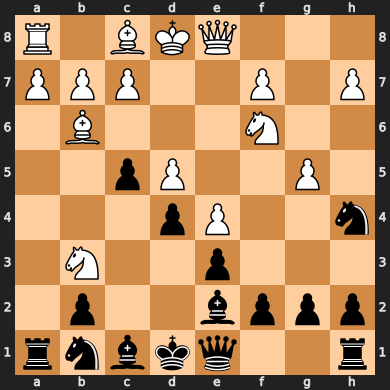

In [23]:
chess.Board(arr[2])

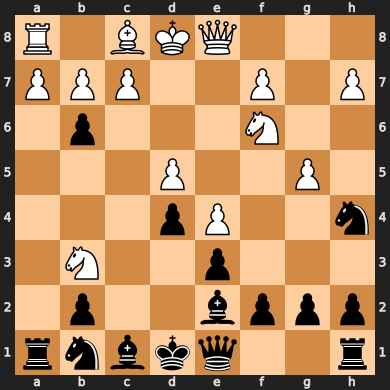

In [25]:
chess.Board(arr[3])

In [82]:
import chess
def detect_moves(prev_fen, curr_fen):
    board = chess.Board(prev_fen)
    curr_board = chess.Board(curr_fen)

    # Find the move that transforms the board
    move = None
    board.turn = True 
    curr_board.turn = False
    for legal_move in board.legal_moves:
        board.push(legal_move)
        if board.fen().split()[0] == curr_fen:
            move = legal_move
            board.pop()
            break
        board.pop()
    if move is None :
        board.turn = False
        curr_board.turn = True
        for legal_move in board.legal_moves:
            board.push(legal_move)
            if board.fen().split()[0] == curr_fen:
                move = legal_move
                board.pop()
                break
            board.pop()

    if move is None:
        #raise ValueError("No legal move found to transition from previous to current position.")
        return None

    # Get the move in PGN notation
    pgn_move = board.san(move)
    # Check for capture
    # if board.is_capture(move):
    #     if pgn_move[0].isupper():  # If it's a piece (not a pawn)

    #         pgn_move = f"{pgn_move[:1]}x{pgn_move[1:]}"
    #     else:  # If it's a pawn, add file notation
    #         from_square_file = chess.square_name(move.from_square)[0]
    #         pgn_move = f"{from_square_file}x{pgn_move}"

    # # Check for check
    # if curr_board.is_check():
    #     pgn_move += "+"

    return pgn_move, board.turn

# Detect the move

k = 1
out = ""
first = True
# print(arr[2], arr[3])
# print(detect_moves(arr[2], arr[3]))
for i in range( len(arr)-1):
    # states[i] = preprocess_board_state(states[i])
    res = detect_moves(arr[i][::-1], arr[i+1][::-1])
    if res is None:
        if i+2<len(arr): 
            res = detect_moves(arr[i][::-1], arr[i+2][::-1])
    # if res is None :
    #     if i+4<len(arr): 
    #         res = detect_moves(arr[i][::-1], arr[i+4][::-1])
    if res is None : continue
    move, white = res
    if first:
        if white:
            out += str(k)+". "+move+" " 
            first = not first 
        else:
            out += str(k)+"... "+move+" "  
        k+=1
    else:
        out += move+" "
        first = not first

print(out)
print(arr)


1... Kd8 2. Qf7 c6 3... cxd5 4... Qc8 5... Nc6 6. Qb6+ Qb6+ 
['2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2q1', '2RK4/6RP/1P2B3/PK1P1Pp1/4P2P/3p4/bp2p3/3n1p1p', '2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2r1', '2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2q1', '2RK4/6RP/1P2B3/PK1P1Pp1/3pP2P/bp2p3/3n1p1p/q2k2r1', '2RK4/6RP/1P2B3/P2P1Pp1/3pP2P/bp1Qp3/3n1p1p/q2k2r1', '2RK4/6RP/1P2B3/P2P1Pp1/4P2P/3p4/bp1Qp3/3n1p1p', '2RK4/6RP/1P2B3/P2P1Pp1/3pP2P/bp1Qp3/3n1p1p/q2k2r1', '2RK4/6RP/1P2B3/P2P1Pp1/3pP2P/bp1Qp3/3n1p1p/q2k2q1', '2RK4/6RP/1P2B3/P2P1Pp1/3pP2P/bp1Qp3/3n1p1p/q2k2r1', '2RK4/6RP/1P2B3/P2P1Pp1/3pP2P/bp1Qp3/3n1p1p/q2k2q1', '2RK4/6RP/1P2B3/P2P1Pp1/3pP2P/bp1Qp3/3n1p1p/q2k2r1', '2RK4/6RP/1P2B3/P2P1Pp1/3pP2P/bp1Qp3/3n1p1p/q2k2q1', '2RK4/6RP/1P2B3/P2P1Pp1/3pP2P/bp1Qp3/3n1p1p/q2k2r1', '2RK4/6RP/1P2B3/P2P1Pp1/3pP2P/bp1Qp3/3n1p1p/q2k2q1', '2RK4/6RP/1P2B3/P2P1Pp1/3pP2P/bp1Qp3/3n1p1p/q2k2r1', '2RK4/6RP/1P2B3/P2P1Pp1/3pP2P/bp1Qp3/3n1p1p/q2k2q1', '2RK4/6RP/1P2B3/P2P1Pp1/3pP2P/bp1Qp3/3n1p1p/q

In [45]:
res = detect_moves(arr[4][::-1], arr[6][::-1])
print(res)

('Ne7', False)


In [44]:
board1 = chess.Board(arr[4])
board2 = chess.Board(arr[6])

board1.turn = False
print(board1)
board2.turn = False
print(board2)
# board2.push_san("f4g3")
# print(board1.fen())

R . B K Q . . .
P . . . . . . P
. P . . . . . .
. . . P . P . .
. . . p P . R P
. . . . p . p .
. p . . . p . p
q n b k . . r .
R . B K Q . . .
P . . . . . . P
. P . . . . . .
. . . P . P . .
. . . p P . R P
. . . . p . p .
. p . n . p . p
q . b k . . r .


In [ ]:
import pandas as pd
data={
    "row_id":[
        "2_Move_rotate_student.mp4",
        "2_move_student.mp4",
        "4_Move_studet.mp4",
        "6_Move_student.mp4",
        "8_Move_student.mp4",
        "(Bonus)Long_video_student.mp4"
    ],
    "output":[
        "1. h4g6  2. gxg6h8",
        "1... Qh4+ 2. g3",
        "1. Ng6 fxg3 2. Nxh8",
        "1... Bxb5 2. Rxb5 b6 3. c4 Ne7 4. Rb2",
        "1... Kd8 2. Qf7 c6 3. cxd5 Qc8 4. Nc6 Qb6+",
        "1. "
    ]
}
df = pd.DataFrame(data)
df.to_csv("submission.csv", index=False, encoding="utf-8")